In [1]:
!pip install xgboost pandas numpy scikit-learn matplotlib seaborn

In [6]:
import json
import numpy as np
import pandas as pd
import os

# Caminhos dos arquivos
caminho_json = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\Embeddings\dados_processos_cejusc_03072025_V1_enriquecidos_Embeddings.json"
caminho_embeddings = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\Embeddings\dados_processos_cejusc_14052025_V1_enriquecidos_Embeddings.npy"

# Carregar JSON enriquecido
with open(caminho_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

df = pd.DataFrame(dados)

# Carregar embeddings
vetores_texto = np.load(caminho_embeddings)

print(f"Dados carregados: {df.shape}")
print(f"Embeddings carregados: {vetores_texto.shape}")

Dados carregados: (4915, 40)
Embeddings carregados: (11053, 3072)


In [7]:
print(f"Linhas no DataFrame: {df.shape[0]}")
print(f"Linhas nos embeddings: {vetores_texto.shape[0]}")

Linhas no DataFrame: 4915
Linhas nos embeddings: 11053


In [ ]:
# # Se os dados estiverem na mesma ordem (mais comum):
# df = df.iloc[:vetores_texto.shape[0]]

# print(f"Novo shape do DataFrame: {df.shape}")
# print(f"Shape dos embeddings: {vetores_texto.shape}")

Novo shape do DataFrame: (4915, 40)
Shape dos embeddings: (11053, 3072)


In [8]:
# ===============================
# Identificar features estruturadas
# ===============================

# Prefixos relevantes para features semânticas e heurísticas
prefixos_struct = (
    "tem_", "n_", "tipo_", "cita_", "pede_",
    "houve_", "tentou_", "usa_", "problema_", "citou_"
)

# Selecionar colunas com esses prefixos
colunas_struct = [col for col in df.columns if col.startswith(prefixos_struct)]
print("Features estruturadas:", colunas_struct)

# Tratar colunas categóricas (ex: tipo_parte_ativa)
colunas_categoricas = [col for col in colunas_struct if df[col].dtype == 'object']
df = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

# Atualizar lista de colunas após get_dummies
colunas_struct_final = [col for col in df.columns if col.startswith(prefixos_struct)]

# Garantir que todas as features estejam em formato numérico
X_struct = df[colunas_struct_final].fillna(0).astype(float).values

# ===============================
# Combinar com embeddings
# ===============================

X = np.hstack((vetores_texto, X_struct))

# ===============================
# Definir alvo (y)
# ===============================

y = df["classificacao"].map({'frutifero': 1, 'infrutifero': 0}).values

Features estruturadas: ['tipo_parte_passiva', 'tipo_parte_ativa', 'tipo_relacao_partes_igual', 'cita_sumula_juris', 'tem_execucao', 'tem_acordo', 'tem_dano_moral', 'tem_protesto', 'tem_penhora', 'tem_repeticao_indebito', 'tem_inexistencia_relacao', 'tem_valor_monetario', 'n_artigos_lei', 'n_tokens_chave', 'pede_tutela_antecipada', 'houve_sentenca_favoravel', 'tentou_conciliacao', 'usa_fundamento_constitucional', 'problema_de_saude', 'citou_dano_moral_indiretamente']


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 11053 and the array at index 1 has size 4915

In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Instanciar o modelo
modelo = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, eval_metric='logloss')

# Treinar
modelo.fit(X_train, y_train)

# Avaliação no teste
y_pred = modelo.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.68      0.64      1754
           1       0.56      0.48      0.52      1493

    accuracy                           0.59      3247
   macro avg       0.59      0.58      0.58      3247
weighted avg       0.59      0.59      0.59      3247



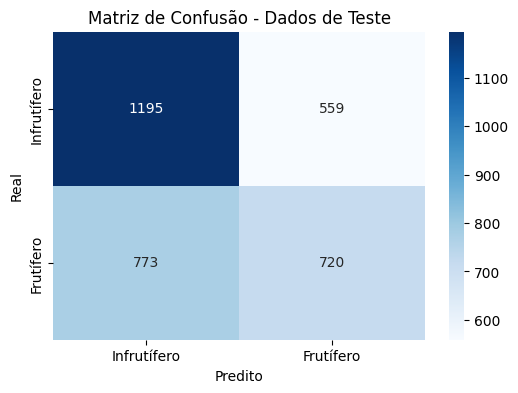

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Infrutífero", "Frutífero"], 
            yticklabels=["Infrutífero", "Frutífero"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Dados de Teste")
plt.show()

In [14]:
# Predição na base inteira (sem olhar para a classificação)
y_pred_real = modelo.predict(X)

# Comparação com os rótulos verdadeiros
mapa_label = {0: "Infrutífero", 1: "Frutífero"}

acertos = 0
total = len(y)

for i in range(total):
    real = y[i]
    pred = y_pred_real[i]
    status = "ACERTOU" if real == pred else "ERROU"
    print(f"{i+1:03d} | Real: {mapa_label[real]:12} | Predito: {mapa_label[pred]:12} | {status}")
    if real == pred:
        acertos += 1

print("\nRESUMO FINAL")
print(f"Acertos: {acertos}/{total}")
print(f"Acurácia: {acertos/total:.2%}")


001 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
002 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
003 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
004 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
005 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
006 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
007 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
008 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
009 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
010 | Real: Frutífero    | Predito: Infrutífero  | ERROU
011 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
012 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
013 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
014 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
015 | Real: Frutífero    | Predito: Frutífero    | ACERTOU
016 | Real: Infrutífero  | Predito: Infrutífero  | ACERTOU
017 | Real: Frutífero    | Predito: Frutífero    | ACERTOU

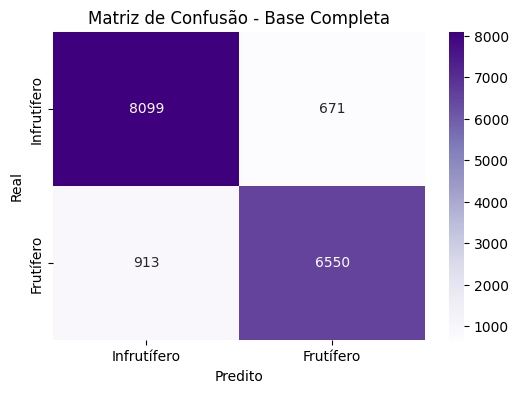

In [11]:
cm = confusion_matrix(y, y_pred_real)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=["Infrutífero", "Frutífero"], 
            yticklabels=["Infrutífero", "Frutífero"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Base Completa")
plt.show()

In [ ]:
import joblib

caminho_modelo = r"C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\app\modelo_xgboost_final.pkl"
joblib.dump(modelo, caminho_modelo)
print("Modelo salvo em:", caminho_modelo)


In [15]:
# --- Instalar dependências (só no Colab ou primeira vez)
!pip install xgboost pandas numpy scikit-learn matplotlib seaborn

In [16]:
# --- Carregar JSON e embeddings
import json
import numpy as np
import pandas as pd

caminho_json = r"C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\dados\dados_processos_cejusc_enriquecidos.json"
caminho_embeddings = r"C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\dados\Embeddings\vetoress_texto.npy"

with open(caminho_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

df = pd.DataFrame(dados)
vetores_texto = np.load(caminho_embeddings)

min_len = min(len(df), len(vetores_texto))
df = df.iloc[:min_len].reset_index(drop=True)
vetores_texto = vetores_texto[:min_len]

In [17]:
# --- Selecionar features estruturadas
prefixos_struct = (
    "tem_", "n_", "tipo_", "cita_", "pede_",
    "houve_", "tentou_", "usa_", "problema_", "citou_"
)

colunas_struct = [col for col in df.columns if col.startswith(prefixos_struct)]
colunas_categoricas = [col for col in colunas_struct if df[col].dtype == 'object']
df = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

colunas_struct_final = [col for col in df.columns if col.startswith(prefixos_struct)]
X_struct = df[colunas_struct_final].fillna(0).astype(float).values

X = np.hstack((vetores_texto, X_struct))
y = df["classificacao"].map({'frutifero': 1, 'infrutifero': 0}).values

print(f"Shape X: {X.shape} | y: {y.shape}")

Shape X: (16233, 3092) | y: (16233,)


In [18]:
# --- Treinar modelo com balanceamento e avaliar
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Balanceamento automático
ratio = sum(y_train == 0) / sum(y_train == 1)

modelo = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    eval_metric='logloss',
    use_label_encoder=False
)

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(classification_report(y_test, y_pred))

c:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:18:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.61      0.63      0.62      1754
           1       0.54      0.52      0.53      1493

    accuracy                           0.58      3247
   macro avg       0.58      0.58      0.58      3247
weighted avg       0.58      0.58      0.58      3247



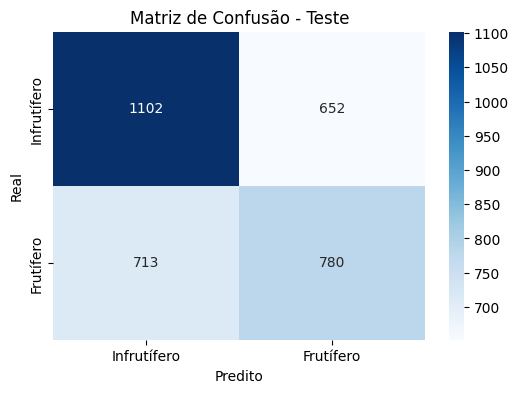

In [19]:
# --- Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Infrutífero", "Frutífero"],
            yticklabels=["Infrutífero", "Frutífero"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Teste")
plt.show()

In [20]:
# --- K-Fold cross-validation
from sklearn.model_selection import cross_val_score

modelo_cv = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    eval_metric='logloss',
    use_label_encoder=False
)

scores = cross_val_score(modelo_cv, X, y, cv=5, scoring='f1')
print(f"F1 Médio (5-Fold): {scores.mean():.4f}")

c:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:19:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:22:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:23:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\willgnnerferreira\Documents\Modelos\Perfil-Concil

F1 Médio (5-Fold): 0.5156


In [21]:
# --- Análise de erros no conjunto completo
y_pred_all = modelo.predict(X)
df["y_real"] = y
df["y_pred"] = y_pred_all
df["erro"] = (df["y_real"] != df["y_pred"]).astype(int)

print(f"Total de erros: {df['erro'].sum()} / {len(df)}")
df_erros = df[df["erro"] == 1]
df_erros[["classificacao", "y_pred"]].head(10)

Total de erros: 1624 / 16233


,classificacao,y_pred
9,frutifero,0
24,infrutifero,1
33,infrutifero,1
34,frutifero,0
43,frutifero,0
74,frutifero,0
76,frutifero,0
86,infrutifero,1
91,frutifero,0
97,infrutifero,1


In [23]:
print(df.columns.tolist())

['numero_processo', 'comarca', 'serventia', 'assunto', 'classe', 'polo_ativo', 'polo_passivo', 'cpf_cnpj_polo_ativo', 'cpf_cnpj_polo_passivo', 'inteiro_teor', 'codg_cnj_audi', 'codg_cnj_julgamento', 'classificacao', 'inteiro_teor_limpo', 'tipo_relacao_partes_igual', 'eh_ente_publico', 'valor_causa', 'num_sentencas', 'comprimento_medio_sentenca', 'cita_sumula_juris', 'tem_execucao', 'tem_acordo', 'tem_dano_moral', 'tem_protesto', 'tem_penhora', 'tem_repeticao_indebito', 'tem_inexistencia_relacao', 'tem_valor_monetario', 'n_artigos_lei', 'n_tokens_chave', 'pede_tutela_antecipada', 'houve_sentenca_favoravel', 'tentou_conciliacao', 'usa_fundamento_constitucional', 'problema_de_saude', 'citou_dano_moral_indiretamente', 'resposta_modelo_classificacao', 'tipo_parte_passiva_cpf', 'tipo_parte_ativa_cpf', 'y_real', 'y_pred', 'erro']


In [30]:
# --- Análise de erros no conjunto completo
y_pred_all = modelo.predict(X)
df["y_real"] = y
df["y_pred"] = y_pred_all
df["erro"] = (df["y_real"] != df["y_pred"]).astype(int)

print(f"Total de erros: {df['erro'].sum()} / {len(df)}")

# Mostrar os erros com número do processo
df_erros = df[df["erro"] == 1]
df_erros[["numero_processo", "classificacao", "y_pred"]].head(50)

Total de erros: 1624 / 16233


,numero_processo,classificacao,y_pred
9,5439667.53.2024.8.09.0007,frutifero,0
24,5442611.28.2024.8.09.0007,infrutifero,1
33,5442718.89.2024.8.09.0066,infrutifero,1
34,5442720.27.2024.8.09.0012,frutifero,0
43,5441863.13.2024.8.09.0163,frutifero,0
74,5443063.69.2024.8.09.0029,frutifero,0
76,5443117.04.2024.8.09.0007,frutifero,0
86,5442226.45.2024.8.09.0051,infrutifero,1
91,5442336.28.2024.8.09.0024,frutifero,0
97,5444472.39.2024.8.09.0075,infrutifero,1


In [31]:
# Resumo de erros por tipo
erros_por_tipo = df_erros.groupby(["classificacao", "y_pred"]).size().reset_index(name="quantidade")
print(erros_por_tipo)

  classificacao  y_pred  quantidade
0     frutifero       0         810
1   infrutifero       1         814


In [32]:
# Salvar todos os erros para auditoria externa
CAMINHO_ERROS = r"C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\resultados_erros.csv"

df_erros[["numero_processo", "classificacao", "y_pred"]].to_csv(
    CAMINHO_ERROS, sep=";", index=False, encoding="utf-8-sig"
)

print(f"Arquivo de erros salvo em: {CAMINHO_ERROS}")


Arquivo de erros salvo em: C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\resultados_erros.csv


In [34]:
!pip install openpyxl

CAMINHO_EXCEL = r"C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\erros_classificacao.xlsx"

df_erros[["numero_processo", "classificacao", "y_pred"]].to_excel(
    CAMINHO_EXCEL, index=False, engine="openpyxl"
)

print(f"Arquivo exportado para: {CAMINHO_EXCEL}")


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Arquivo exportado para: C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\erros_classificacao.xlsx


In [35]:
from sklearn.metrics import classification_report

print(classification_report(df["y_real"], df["y_pred"], target_names=["infrutifero", "frutifero"]))

              precision    recall  f1-score   support

 infrutifero       0.91      0.91      0.91      8770
   frutifero       0.89      0.89      0.89      7463

    accuracy                           0.90     16233
   macro avg       0.90      0.90      0.90     16233
weighted avg       0.90      0.90      0.90     16233



In [36]:
# Adiciona probabilidade (opcional)
df["prob_frutifero"] = modelo.predict_proba(X)[:, 1]

# Recalcula predição e acerto
df["y_pred"] = modelo.predict(X)
df["acertou"] = (df["y_pred"] == df["y_real"]).astype(int)

# Exportar todos os dados
CAMINHO_COMPLETO = r"C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\resultados_completos_classificacao.xlsx"

df[["numero_processo", "classificacao", "y_pred", "acertou", "prob_frutifero"]].to_excel(
    CAMINHO_COMPLETO, index=False, engine="openpyxl"
)

print(f"Arquivo completo exportado em: {CAMINHO_COMPLETO}")


Arquivo completo exportado em: C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\resultados_completos_classificacao.xlsx


In [22]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, confusion_matrix, classification_report
)

# Métricas
acc = accuracy_score(df["y_real"], df["y_pred"])
prec = precision_score(df["y_real"], df["y_pred"])
rec = recall_score(df["y_real"], df["y_pred"])
f1 = f1_score(df["y_real"], df["y_pred"])
mcc = matthews_corrcoef(df["y_real"], df["y_pred"])

print("======= MÉTRICAS NO CONJUNTO COMPLETO =======")
print(f"Acurácia:  {acc:.4f}")
print(f"Precisão:  {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")

======= MÉTRICAS NO CONJUNTO COMPLETO =======
Acurácia:  0.9000
Precisão:  0.8910
Recall:    0.8915
F1-Score:  0.8912
MCC:       0.7986


In [ ]:
# --- Salvar modelo treinado
import joblib

caminho_modelo = r"C:\Users\willgnnerferreira\Documents\Modelos\Perfil-Conciliação-Xgboost-GCP\app\modelo_xgboost_final.pkl"
joblib.dump(modelo, caminho_modelo)
print("Modelo salvo em:", caminho_modelo)